# 11. Ensemble models 

The first step is to activate the packages and load the data.

In [1]:
import quandl
import pyreadr
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime as dt
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

import xgboost as xgb
from sklearn.metrics import  mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import layers
np.random.seed(0)

In [3]:
#data_ml = pyreadr.read_r(insert path of data_ml.RData)["data_ml"]
data_ml.date = pd.to_datetime(data_ml.date)

data_ml = data_ml.loc[(data_ml['date'] > "1999-12-31") & (data_ml['date'] < "2019-01-01")]
data_ml.sort_values(by = ['stock_id','date'], inplace = True)

We also copy/paste some chunks from Chapter 2.


In [4]:
stock_ids = data_ml.stock_id.unique() 
stock_days = data_ml.stock_id.value_counts().sort_index() 
stock_ids_short = stock_ids[stock_days.values == max(stock_days.values)]

returns_short = data_ml[data_ml['stock_id'].isin(stock_ids_short)][['date','stock_id','R1M_Usd']]
returns = returns_short.pivot_table(index=['date'],columns='stock_id',values='R1M_Usd')  
features = list(data_ml.columns[2:95]) 
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", 
                    "Ocf", "Pb", "Vol1Y_Usd"]
data_ml['R1M_Usd_C'] = data_ml.R1M_Usd >  data_ml.groupby('date').R1M_Usd.transform('median')
data_ml['R12M_Usd_C'] = data_ml.R12M_Usd >  data_ml.groupby('date').R12M_Usd.transform('median')
separation_date = dt.strptime("2014-01-15","%Y-%m-%d")
training_sample = data_ml[data_ml.date < separation_date]
testing_sample = data_ml[data_ml.date  >= separation_date]

Ensemble models require several models as inputs. Thus, we need to rebuild four models created in the previous chapters. This is going to take some code and some time. Strangely, for clarity, we gather all of it in just one (too) big chunk.


In [5]:
fit_tree = DecisionTreeRegressor(min_samples_leaf = 35, #The minimum number of samples required to be at a leaf node.change variable 3500 to 35 
                                min_samples_split = 800,#The minimum number of samples required to split an internal node. change variable 8000 to 800 
                                ccp_alpha = 0.0001,     #Complexity parameter used for Minimal Cost-Complexity Pruning. smaller cp = more leaves
                                max_depth = 3)          #The maximum depth of the tree
fit_tree.fit(data_ml[features], data_ml.R1M_Usd)

DecisionTreeRegressor(ccp_alpha=0.0001, max_depth=3, min_samples_leaf=35,
                      min_samples_split=800)

In [6]:
fit_RF = RandomForestRegressor( max_samples = 10000,    #If bootstrap is True, the number of samples to draw from X to train each base estimator.
                                bootstrap = False,     #Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.
                                min_samples_leaf= 250,  #The minimum number of samples required to be at a leaf node. 
                                n_estimators = 40,      #The number of trees in the forest.
                                max_features = 30)      #The number of features to consider when looking for the best split:
fit_RF.fit(training_sample[features], training_sample.R1M_Usd)

RandomForestRegressor(bootstrap=False, max_features=30, max_samples=10000,
                      min_samples_leaf=250, n_estimators=40)

In [7]:
top20 = training_sample.R1M_Usd.quantile(0.8) 
bottom20= training_sample.R1M_Usd.quantile(0.2)
train_features = training_sample[training_sample.R1M_Usd>top20]
train_features = train_features.append(training_sample[training_sample.R1M_Usd<bottom20])
train_features = train_features.sort_values(by=['stock_id','date'])
train_features_xgb = train_features[features_short]
train_label_xgb = train_features.R1M_Usd
mono_const = np.zeros(len(features))
mono_const += (np.array(features)=='Mkt_Cap_12M_Usd' ) * -1
mono_const += (np.array(features)=='Pb' ) * -1
mono_const += (np.array(features)=='Mom_11M_Usd' ) * 1
fit_xgb = xgb.XGBRegressor(     
              learning_rate  = 0.3,                                                        #Boosting learning rate                 
              objective = "reg:linear",                                                    #Specify the learning task and the corresponding learning objective or a custom objective function to be used      
              max_depth = 4,                                                               #Maximum tree depth for base learners.
              reg_lambda = 1,                                                              #L2 regularization term on weights
              gamma = 0.1,                                                                 #Minimum loss reduction required to make a further partition on a leaf node of the tree.
              n_estimators = 30,                                                           #Number of trees in random forest to fit.
              monotone_constraints = '('+','.join(str(int(x)) for x in mono_const) + ')', #Constraint of variable monotonicity. See tutorial for more information.
              verbosity  = 0)                                                              #The degree of verbosity

fit_xgb.fit(train_features_xgb,train_label_xgb )
xgb_test = testing_sample[features_short]

In [8]:
NN_train_features = training_sample[features]
NN_train_labels = training_sample.R1M_Usd
NN_test_features = testing_sample[features]
NN_test_labels = testing_sample.R1M_Usd
model = Sequential()
model.add(layers.Dense(16, activation="relu", input_shape = (len(NN_train_features.columns),) ))
model.add(layers.Dense(8, activation="sigmoid"))
model.add(layers.Dense(1))
model.compile(loss='MeanSquaredError',
              optimizer='RMSprop',
              metrics='MeanAbsoluteError' )
fit_NN = model.fit(NN_train_features, NN_train_labels,
                  epochs = 10, batch_size = 512,
                  validation_data = (NN_test_features, NN_test_labels))


Epoch 1/10
387/387 [==============================] - 1s 1ms/step - loss: 0.0311 - mean_absolute_error: 0.0902 - val_loss: 0.0371 - val_mean_absolute_error: 0.0669
Epoch 2/10
387/387 [==============================] - 0s 939us/step - loss: 0.0290 - mean_absolute_error: 0.0841 - val_loss: 0.0372 - val_mean_absolute_error: 0.0679
Epoch 3/10
387/387 [==============================] - 0s 941us/step - loss: 0.0290 - mean_absolute_error: 0.0840 - val_loss: 0.0371 - val_mean_absolute_error: 0.0674
Epoch 4/10
387/387 [==============================] - 0s 967us/step - loss: 0.0289 - mean_absolute_error: 0.0839 - val_loss: 0.0371 - val_mean_absolute_error: 0.0674
Epoch 5/10
387/387 [==============================] - 0s 967us/step - loss: 0.0289 - mean_absolute_error: 0.0839 - val_loss: 0.0370 - val_mean_absolute_error: 0.0670
Epoch 6/10
387/387 [==============================] - 0s 954us/step - loss: 0.0289 - mean_absolute_error: 0.0839 - val_loss: 0.0373 - val_mean_absolute_error: 0.0685
Epoch 

Then, we can move on to the aggregation.


In [9]:
err_tree_train = fit_tree.predict(training_sample[features]) - training_sample.R1M_Usd       
err_RF_train  = fit_RF.predict(training_sample[features]) - training_sample.R1M_Usd           
pred_XGB_train = fit_xgb.predict(train_features_xgb)
err_XGB_train = np.append(np.repeat(pred_XGB_train, len(training_sample)//len(pred_XGB_train)),
                  pred_XGB_train[:len(training_sample)- len(training_sample)//len(pred_XGB_train)*
                                 len(pred_XGB_train)]) \
                - training_sample.R1M_Usd  
err_NN_train =  model.predict(NN_train_features).flatten() - training_sample.R1M_Usd                 
E = pd.DataFrame({"err_tree_train":err_tree_train,"err_RF_train":err_RF_train,
                  "err_XGB_train":err_XGB_train,"err_NN_train":err_NN_train})                                                                        

In [10]:
E.corr()

,err_tree_train,err_RF_train,err_XGB_train,err_NN_train
err_tree_train,1.000000,0.992657,0.943516,0.993881
err_RF_train,0.992657,1.000000,0.943599,0.997766
err_XGB_train,0.943516,0.943599,1.000000,0.945210
err_NN_train,0.993881,0.997766,0.945210,1.000000


As is shown by the correlation matrix, the models fail to generate heterogeneity in their predictions. 


In [11]:
E.apply(lambda x: abs(x)).mean()

err_tree_train    0.083680
err_RF_train      0.081785
err_XGB_train     0.089059
err_NN_train      0.083494
dtype: float64

The best performing ML engine is the random forest. The boosted tree model is the worst, by far. Below, we compute the optimal (non constrained) weights for the combination of models. 


In [12]:
w_ensemble = np.matmul(np.linalg.inv(E.T.dot(E)), np.ones(4))
w_ensemble = w_ensemble / sum(w_ensemble)
w_ensemble

array([-0.08815899,  3.50935503, -0.02895866, -2.39223739])

Because of the high correlations, the optimal weights are not balanced and diversified: they load heavily on the random forest learner (best in sample model) and 'short' a few models in order to compensate.

Note that the weights are of course computed with **training errors**. The optimal combination is then tested on the testing sample. Below, we compute out-of-sample (testing) errors and their average absolute value.

In [13]:
err_tree_test = fit_tree.predict(testing_sample[features]) - testing_sample.R1M_Usd       
err_RF_test  = fit_RF.predict(testing_sample[features]) - testing_sample.R1M_Usd           
err_XGB_test = fit_xgb.predict(xgb_test) - testing_sample.R1M_Usd  
err_NN_test =  model.predict(NN_test_features)[1] - testing_sample.R1M_Usd                 
E_test = pd.DataFrame({"err_tree_test":err_tree_test,"err_RF_test":err_RF_test,
                  "err_XGB_test":err_XGB_test,"err_NN_test":err_NN_test}) 
E_test.apply(lambda x: abs(x)).mean()

err_tree_test    0.066311
err_RF_test      0.067180
err_XGB_test     0.071490
err_NN_test      0.066015
dtype: float64

The boosted tree model is still the worst performing algorithm while the simple models (regression and simple tree) are the ones that fare the best. The most naive combination is the simple average of model and predictions.


In [14]:
err_EW_test = E_test.mean(axis=1).apply(lambda x: abs(x)).mean()
err_EW_test

0.0668485811598183

Because the errors are very correlated, the equally-weighted combination of forecasts yields an average error which lies 'in the middle' of individual errors. The diversification benefits are too small. Let us now test the 'optimal' combination.


In [15]:
err_opt_test = E_test.multiply(w_ensemble,axis=1)
err_opt_test.mean(axis=1).apply(lambda x: abs(x)).mean()


0.019642144394636553

Again, the result is disappointing because of the lack of diversification across models. The correlations between errors are high not only on the training sample, but also on the testing sample, as shown below.


In [16]:
E_test.corr()

,err_tree_test,err_RF_test,err_XGB_test,err_NN_test
err_tree_test,1.000000,0.994076,0.971068,0.997389
err_RF_test,0.994076,1.000000,0.980279,0.995613
err_XGB_test,0.971068,0.980279,1.000000,0.970677
err_NN_test,0.997389,0.995613,0.970677,1.000000


The leverage from the optimal solution only exacerbates the problem and underperforms the heuristic uniform combination. We end this section with the constrained formulation of @breiman1996stacked using the *quadprog* package. If we write $\mathbf{\Sigma}$ for the covariance matrix of errors, we seek
$$\mathbf{w}^*=\underset{\mathbf{w}}{\text{argmin}} \ \mathbf{w}'\mathbf{\Sigma}\mathbf{w}, \quad \mathbf{1}'\mathbf{w}=1, \quad w_i\ge 0,$$

The constraints will be handled as:

$$\mathbf{A} \mathbf{w}= \begin{bmatrix} 
1 & 1 & 1 \\
1 & 0 & 0\\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix} \mathbf{w} \hspace{9mm} \text{ compared to} \hspace{9mm} \mathbf{b}=\begin{bmatrix} 1 \\ 0 \\ 0 \\ 0 \end{bmatrix},  $$

where the first line will be an equality (weights sum to one) and the last three will be inequalities (weights are all positive).

In [17]:
def solve_qp_scipy(G, a, C, b, meq=0):
    # Minimize     1/2 x^T G x - a^T x
    # Subject to   C.T x >= b
    def f(x):
        return 1/2 * np.dot(x, G).dot(x) - np.dot(a, x)
    constraints = [{
        'type': 'ineq',
        'fun': lambda x, C=C, b=b, i=i: (np.dot(C.T, x) - b)[i]
    } for i in range(C.shape[1])]

    result = scipy.optimize.minimize(
        f, x0=np.zeros(len(G)), method='COBYLA', constraints=constraints,
        tol=1e-10, options={'maxiter': 2000})
    return result

In [18]:
Sigma = E.T.dot(E)
nb_mods = len(Sigma)
w_const = solve_qp_scipy(G = Sigma,
                         a = np.zeros(nb_mods),
                         C = np.vstack((np.ones(nb_mods), np.diag(np.ones(nb_mods)))).T,
                         b = np.append(np.ones(1), np.zeros(nb_mods))
                        )
w_const

     fun: 2768.4744088066573
   maxcv: -0.0
 message: 'Optimization terminated successfully.'
    nfev: 57
  status: 1
 success: True
       x: array([0., 1., 0., 0.])

Compared to the unconstrained solution, the weights are sparse and concentrated in one or two models, usually those with small training sample errors. 

Below, we turn to stacked ensembles. The overarching layer is a neural network.

In [19]:
model_stack = Sequential()
model_stack.add(layers.Dense(8, activation="relu", input_shape = (nb_mods,)  ))
model_stack.add(layers.Dense(4, activation="tanh"))
model_stack.add(layers.Dense(1))

The configuration is very simple. We do not include any optional arguments and hence the model is likely to overfit. As we seek to predict returns, the loss function is the standard $L^2$ norm.


In [20]:
model_stack.compile(loss='MeanSquaredError',# Loss function
              optimizer='RMSprop',          # Optimisation method (weight updating)
              metrics='MeanAbsoluteError' ) # Output metric
model_stack.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [21]:
y_tilde = E + np.tile(training_sample.R1M_Usd,(nb_mods,1)).T
y_test = E_test+ np.tile(testing_sample.R1M_Usd,(nb_mods,1)).T

fit_NN = model_stack.fit(y_tilde,                                             # Training features
                   training_sample.R1M_Usd,                             # Training labels
                  epochs = 12, batch_size = 512,                        # Training parameters           
                  validation_data = (y_test, testing_sample.R1M_Usd)  # Test data
                  )

Epoch 1/12
387/387 [==============================] - 0s 843us/step - loss: 0.0283 - mean_absolute_error: 0.0826 - val_loss: 0.0372 - val_mean_absolute_error: 0.0677
Epoch 2/12
387/387 [==============================] - 0s 628us/step - loss: 0.0276 - mean_absolute_error: 0.0819 - val_loss: 0.0375 - val_mean_absolute_error: 0.0696
Epoch 3/12
387/387 [==============================] - 0s 613us/step - loss: 0.0274 - mean_absolute_error: 0.0816 - val_loss: 0.0380 - val_mean_absolute_error: 0.0712
Epoch 4/12
387/387 [==============================] - 0s 623us/step - loss: 0.0272 - mean_absolute_error: 0.0814 - val_loss: 0.0382 - val_mean_absolute_error: 0.0720
Epoch 5/12
387/387 [==============================] - 0s 613us/step - loss: 0.0271 - mean_absolute_error: 0.0812 - val_loss: 0.0387 - val_mean_absolute_error: 0.0739
Epoch 6/12
387/387 [==============================] - 0s 616us/step - loss: 0.0271 - mean_absolute_error: 0.0812 - val_loss: 0.0389 - val_mean_absolute_error: 0.0742
Epoc

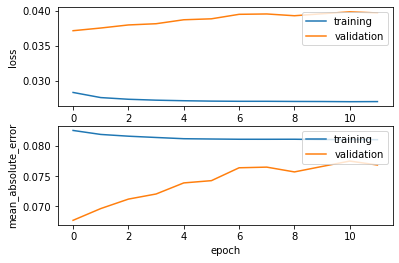

In [22]:
plt.subplot(2,1,1)
plt.plot(fit_NN.history['loss'])
plt.plot(fit_NN.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')

plt.subplot(2,1,2)
plt.plot(fit_NN.history['mean_absolute_error'])
plt.plot(fit_NN.history['val_mean_absolute_error'])
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')

One alternative outside the perimeter of ensembles is to train simple trees on a set of macroeconomic indicators. We test this idea below, using aggregate data from the Federal Reserve of Saint Louis. A simple downloading function is available in the *quandl* package. We download and format the data in the next chunk. CPIAUCSL is a code for consumer price index and T10Y2YM is a code for the term spread (10Y minus 2Y).
To use quandl, you have to get api key. To do this, you sign up "https://www.quandl.com/", then you can check your api in the account page.

In [23]:
quandl.ApiConfig.api_key = "inpuy your key"
cpi = quandl.get("FRED/CPIAUCSL")
cpi['inflation'] = cpi /cpi.shift(periods=1) - 1
cpi = cpi.rename(columns={"Value":"CPIAUCSL"})
cpi.index = cpi.index.rename("Index")

ts = quandl.get("FRED/T10Y2YM")
ts = ts.rename(columns={"Value":"termspread"})
ts.index = ts.index.rename("Index")

In [24]:
ens_data = testing_sample[['date']].join(err_NN_test)
ens_data['Index'] = ens_data.date.apply(lambda x: x.replace(day=1))
ens_data = pd.merge(ens_data, cpi, left_on='Index', right_index=True,how='left')
ens_data = pd.merge(ens_data, ts, left_on='Index', right_index=True,how='left')
ens_data = ens_data.rename(columns={"R1M_Usd":"err_NN_test"})
ens_data.head()

,date,err_NN_test,Index,CPIAUCSL,inflation,termspread
244677,2014-01-31,-0.148263,2014-01-01,235.288,0.002424,2.47
244678,2014-02-28,0.074737,2014-02-01,235.547,0.001101,2.38
239053,2014-03-31,-0.018263,2014-03-01,236.028,0.002042,2.32
239054,2014-04-30,-0.082263,2014-04-01,236.468,0.001864,2.29
239055,2014-05-31,-0.089263,2014-05-01,236.918,0.001903,2.17


We can now build a tree that tries to explain the accuracy of models as a function of macro variables.


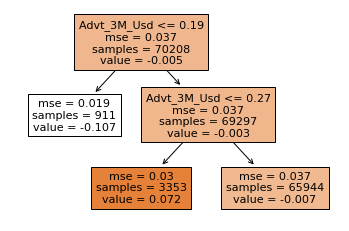

In [25]:
fit_ens = DecisionTreeRegressor(ccp_alpha = 0.0001,     #Complexity parameter used for Minimal Cost-Complexity Pruning. smaller cp = more leaves
                                ) 
fit_ens.fit(ens_data[['inflation','termspread']], err_NN_test)
_ = plot_tree(fit_ens, 
                   feature_names=features,  
                   class_names=data_ml.R1M_Usd,
                   filled=True)

Finally, we train four models on four different years to see if this help reduce the inter-model correlations. This process is a bit lengthy because the samples and models need to be all redefined. We start by creating the four training samples. The third model works on the small subset of features, hence the sample is smaller.


In [26]:
training_sample_2009 = training_sample[(training_sample.date > "2008-12-31") & 
                                       (training_sample.date < "2010-01-01") ]
training_sample_2011 = training_sample[(training_sample.date > "2010-12-31") & 
                                       (training_sample.date < "2012-01-01") ]
training_sample_2013 = training_sample[(training_sample.date > "2012-12-31") & 
                                       (training_sample.date < "2014-01-01") ]

Then, we proceed to the training of the models. The syntaxes are those used in the previous chapters, nothing new here. We start with a random forest. In all predictions below, the original testing sample is used *for all models*.


In [27]:
fit_ens_2009 = RandomForestRegressor( max_samples = 4000,    #If bootstrap is True, the number of samples to draw from X to train each base estimator.
                                      bootstrap = True,     #Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.
                                      min_samples_leaf= 100,  #The minimum number of samples required to be at a leaf node. 
                                      n_estimators = 40,      #The number of trees in the forest.
                                      max_features = 30)      #The number of features to consider when looking for the best split:
fit_ens_2009.fit(training_sample_2009[features], training_sample_2009.R1M_Usd)
err_ens_2009 = fit_ens_2009.predict(testing_sample[features]) - testing_sample.R1M_Usd

The second model is a boosted tree.


In [28]:
train_features_2011 = training_sample_2011[features_short]
train_label_2011 = training_sample_2011.R1M_Usd
fit_ens_2011 = xgb.XGBRegressor(     
              learning_rate  = 0.4,                                                        #Boosting learning rate                 
              objective = "reg:linear",                                                    #Specify the learning task and the corresponding learning objective or a custom objective function to be used      
              max_depth = 4,                                                               #Maximum tree depth for base learners.
              n_estimators = 18                                                           #Number of trees in random forest to fit
                )                                                             
fit_ens_2011.fit(train_features_2011,train_label_2011 )
err_ens_2011 = fit_ens_2011.predict(xgb_test) -  testing_sample.R1M_Usd 

Finally, the last model is a simple neural network.


In [29]:
NN_features_2013 = training_sample_2013[features]
NN_labels_2013 = training_sample_2013.R1M_Usd
model = Sequential()

model.add(layers.Dense(16, activation="relu", input_shape = (len(NN_features_2013.columns),) ))
model.add(layers.Dense(8, activation="tanh"))
model.add(layers.Dense(1))
model.compile(loss='MeanSquaredError',
              optimizer='RMSprop',
              metrics='MeanAbsoluteError' )
model_ens_2013 = model.fit(NN_features_2013, NN_labels_2013,
                  epochs = 9, batch_size = 128)
err_ens_2013 = model.predict(NN_test_features)[1] - testing_sample.R1M_Usd


Epoch 1/9
112/112 [==============================] - 0s 572us/step - loss: 0.0168 - mean_absolute_error: 0.0891
Epoch 2/9
112/112 [==============================] - 0s 518us/step - loss: 0.0075 - mean_absolute_error: 0.0615
Epoch 3/9
112/112 [==============================] - 0s 518us/step - loss: 0.0073 - mean_absolute_error: 0.0604
Epoch 4/9
112/112 [==============================] - 0s 518us/step - loss: 0.0073 - mean_absolute_error: 0.0601
Epoch 5/9
112/112 [==============================] - 0s 509us/step - loss: 0.0072 - mean_absolute_error: 0.0596
Epoch 6/9
112/112 [==============================] - 0s 536us/step - loss: 0.0072 - mean_absolute_error: 0.0593
Epoch 7/9
112/112 [==============================] - 0s 518us/step - loss: 0.0071 - mean_absolute_error: 0.0593
Epoch 8/9
112/112 [==============================] - 0s 518us/step - loss: 0.0071 - mean_absolute_error: 0.0592
Epoch 9/9
112/112 [==============================] - 0s 527us/step - loss: 0.0071 - mean_absolute_error:

Endowed with the errors of the three models, we can compute their correlation matrix.

In [30]:
E_subtraining = pd.DataFrame({'err_ens_2009':err_ens_2009, 'err_ens_2011':err_ens_2011,'err_ens_2013': err_ens_2013})
E_subtraining.corr()

,err_ens_2009,err_ens_2011,err_ens_2013
err_ens_2009,1.000000,0.641060,0.980153
err_ens_2011,0.641060,1.000000,0.646009
err_ens_2013,0.980153,0.646009,1.000000
